What is the purpose of a **Bayesian dynamic linear model**?  
To adapt quickly to sudden changes in time series trend.

In this liveProject you are tasked with implementing a Bayesian dynamic linear model using the [PyDLM library](https://github.com/wwrechard/PyDLM).

The purpose of this exercise is to build a model that can *adapt to significant changes in a time series trend*. This allows the model to generate forecasts that are more adaptive to changes than classical time series forecasting techniques.

#### In this notebook
<a id="top"></a>

- [Dynamic linear modelling](#dynamic-linear-modelling)
- [Forecast Interpretation](#forecast-interpretation)
- [RMSE](#rmse)

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
idx = pd.IndexSlice

In [2]:
!head -n2 data/h2weekly.csv

Date,IsCanceled
2015-06-21,97


In [13]:
data = pd.read_csv('data/h2weekly.csv', parse_dates=['Date'], index_col='Date')

data.info()
data.head(2)
data.tail(2)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115 entries, 2015-06-21 to 2017-08-27
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   IsCanceled  115 non-null    int64
dtypes: int64(1)
memory usage: 1.8 KB


,IsCanceled
Date,
2015-06-21,97
2015-06-28,153


,IsCanceled
Date,
2017-08-20,201
2017-08-27,129


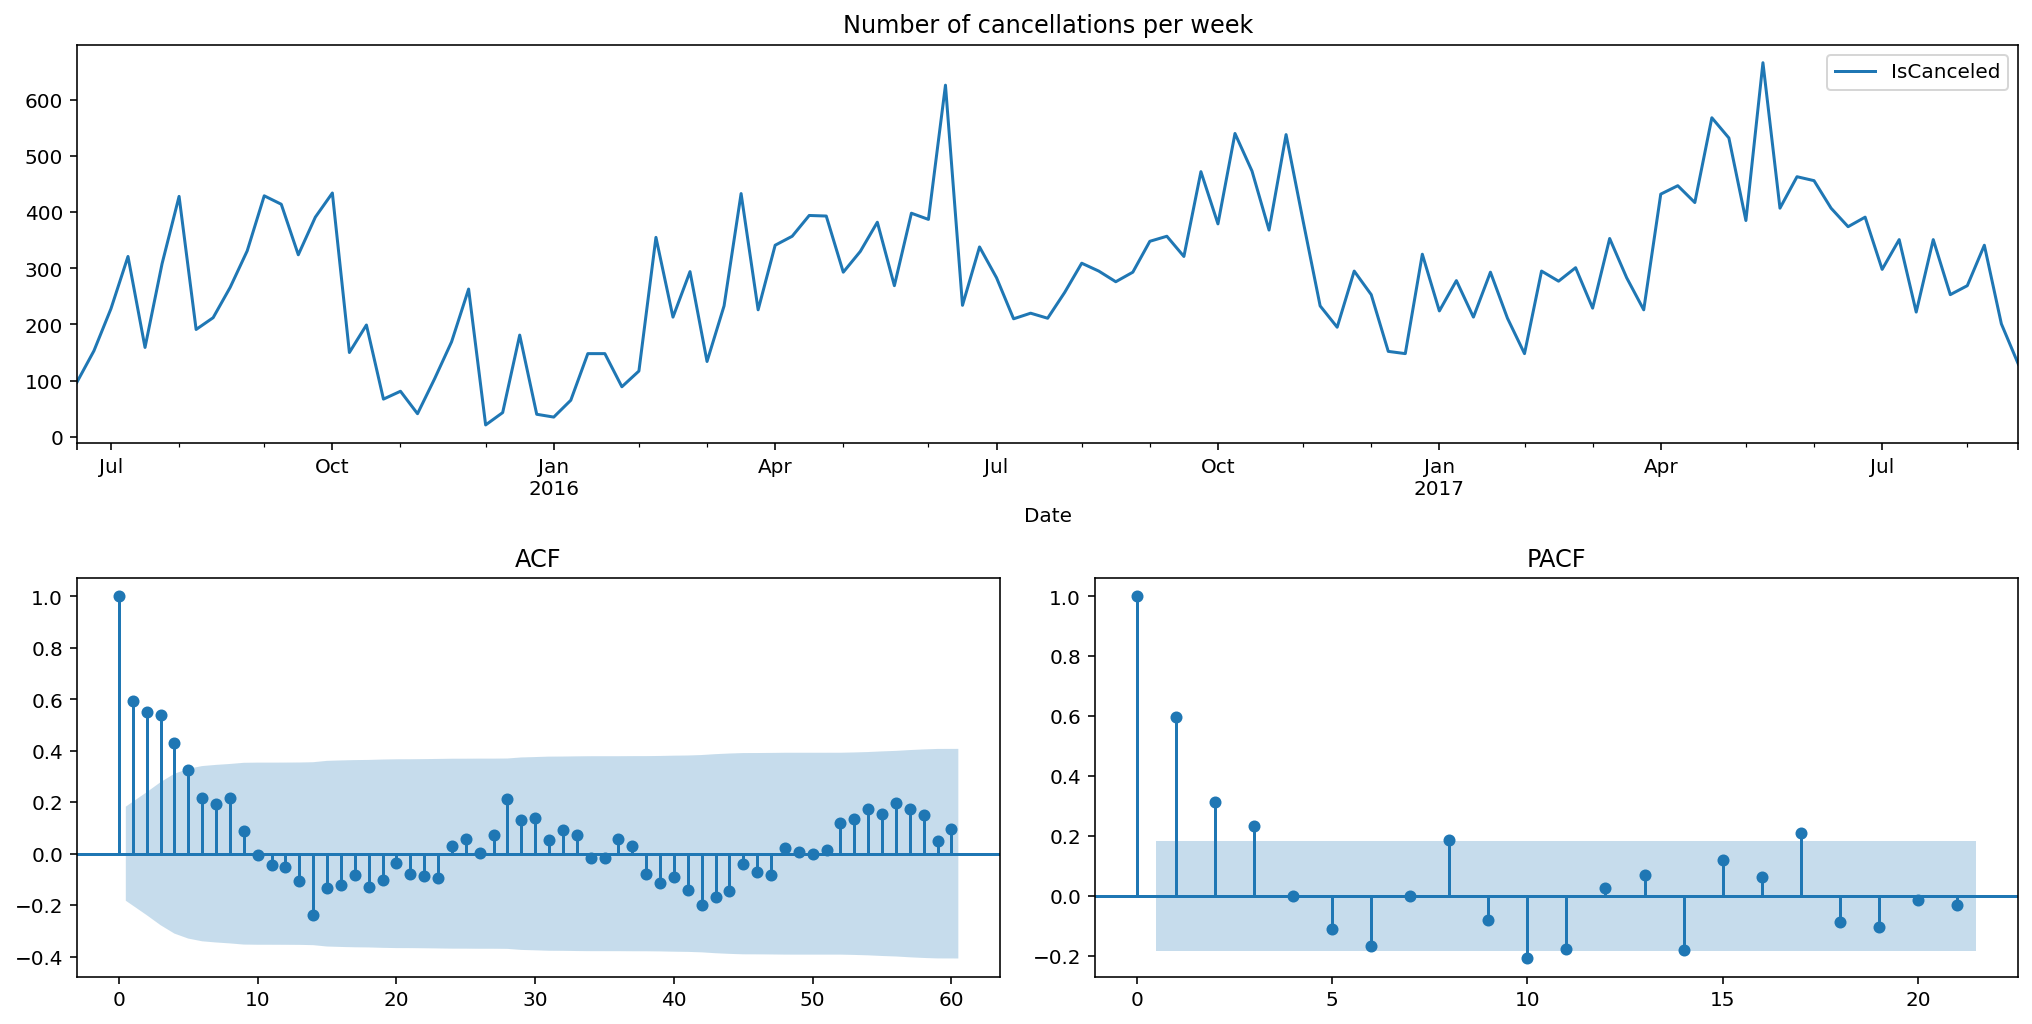

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(14, 7))
gs = fig.add_gridspec(2, 2)

ax_top = fig.add_subplot(gs[0, :])
ax_bot_0 = fig.add_subplot(gs[1, 0])
ax_bot_1 = fig.add_subplot(gs[1, 1])

_ = data.plot(ax=ax_top, title='Number of cancellations per week', label='')
_ = plot_acf(data, ax=ax_bot_0, title='ACF', lags=60)
_ = plot_pacf(data, ax=ax_bot_1, title='PACF')

_ = ax_top.legend()

## Dynamic linear modelling
<a id="dynamic-linear-modelling"></a>
[To the Top](#top)

The [Google data science post example](https://pydlm.github.io/example1.html) as provided by the [PyDLM](https://pydlm.github.io/) documentation was used as a template in building the below models.

Here are some relevant technical terms describing the parameters in the models below:
- **degree** = Autoregressive component, i.e. how many previous time periods to incorporate into future forecasts.
- **discounting factor** = The speed at which the model should adapt to the new data.
- **seasonality period** = Seasonal period of the time series, e.g. hourly, daily, weekly, monthly.
- **w** = the prior guess on the variance of each component, the larger number the more uncertain.

In [4]:
from pydlm import dlm, trend, seasonality

In [14]:
ts = data.values

type(ts)
ts[:5]

numpy.ndarray

array([[ 97],
       [153],
       [228],
       [321],
       [159]])

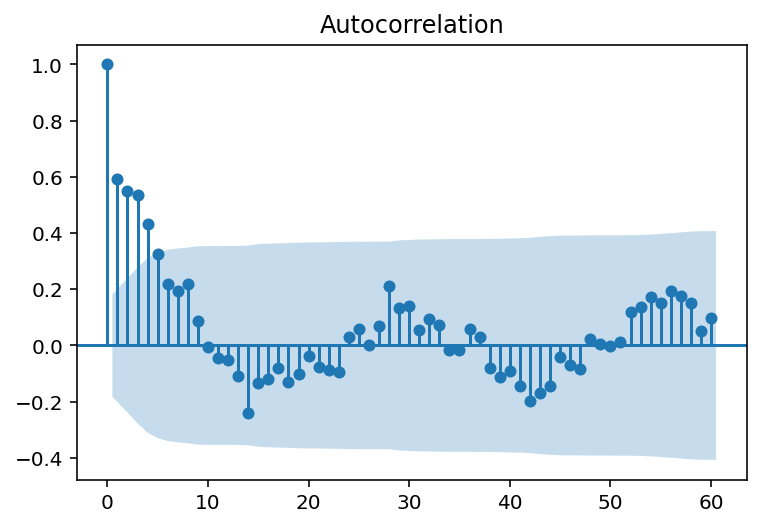

In [18]:
_ = plot_acf(ts, lags=60)

In this particular example, it is observed that the strongest positive correlation after the series of negatively correlated lags comes at lag 28. In this regard, 28 is set as the seasonal parameter when generating the simple and dynamic linear models.

In [15]:
linear_trend = trend(degree=1, discount=0.9, name='linear_trend', w=10)
seasonal28 = seasonality(period=28, discount=0.9, name='seasonal28', w=10)
simple_dlm = dlm(ts) + linear_trend + seasonal28

simple_dlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


/Users/dimitri/opt/miniconda3/envs/ts-forecasting/lib/python3.8/site-packages/pydlm/plot/dlmPlot.py:519: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(size[0]) + str(size[1]) + str(location))


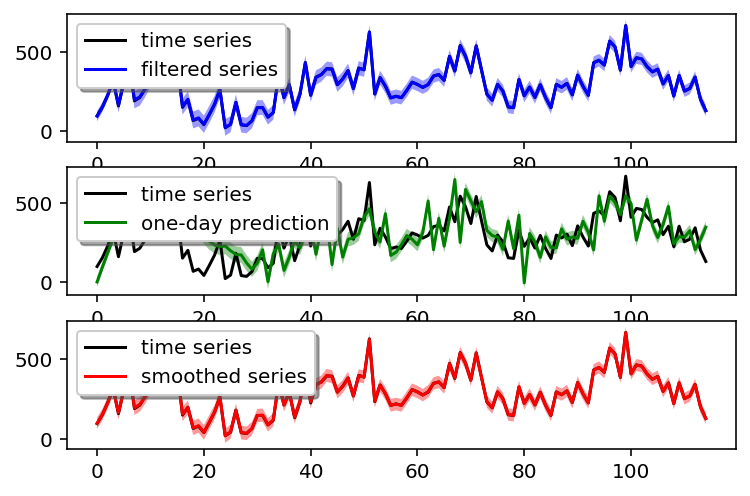

In [21]:
# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()

In [23]:
simple_dlm.ls()

The static components are
linear_trend (degree = 2)
seasonal28 (degree = 28)
 
There is no dynamic component.
 
There is no automatic component.


In [24]:
np.sqrt(simple_dlm.getMSE())

124.28653141706431

#### Tunning

The model is tuned using gradient descent, with the mean squared error as the loss function.

In [25]:
from pydlm import modelTuner

In [26]:
%%time

myTuner = modelTuner(method='gradient_descent', loss='mse')
tunedDLM = myTuner.tune(simple_dlm, maxit=100)

The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
CPU times: user 25.6 s, sys: 151 ms, total: 25.7 s
Wall time: 25.8 s


/Users/dimitri/opt/miniconda3/envs/ts-forecasting/lib/python3.8/site-packages/pydlm/plot/dlmPlot.py:519: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(size[0]) + str(size[1]) + str(location))


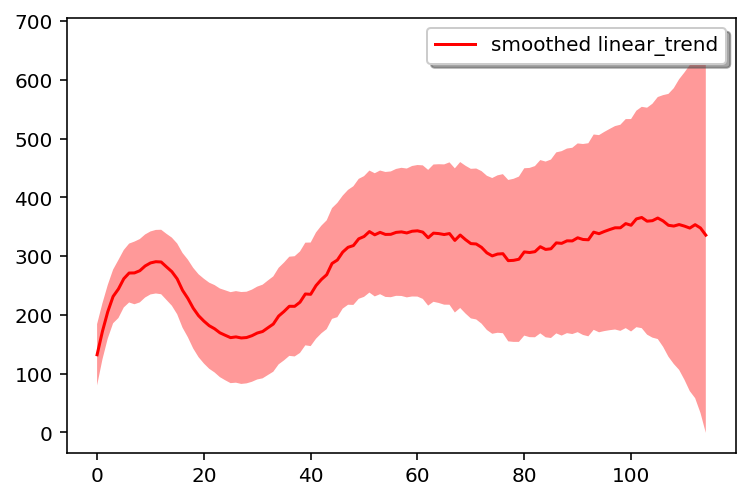

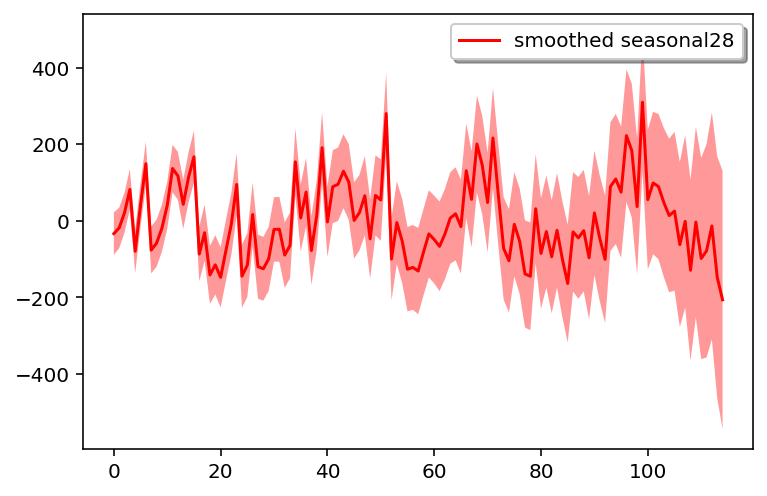

In [27]:
# Plot the linear and seasonal trends.
simple_dlm.turnOff('predict plot')
simple_dlm.turnOff('filtered plot')
simple_dlm.plot('linear_trend')
simple_dlm.plot('seasonal28')

## Forecast Interpretation
<a id="forecast-interpretation"></a>
[To the Top](#top)

In [28]:
len(ts)

115

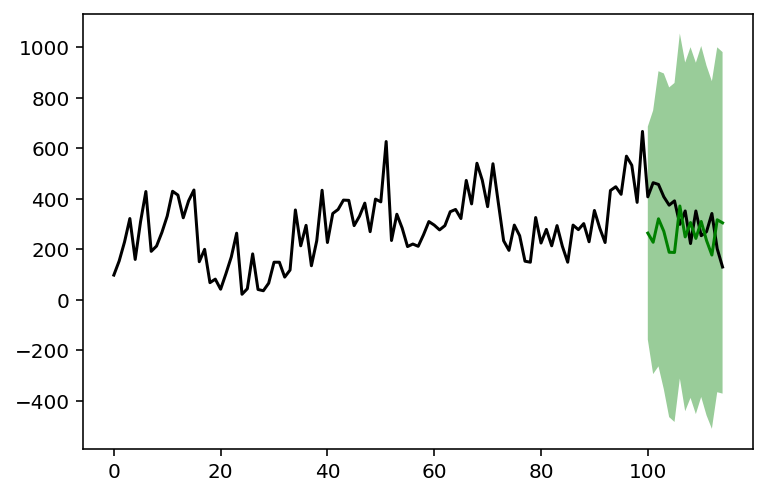

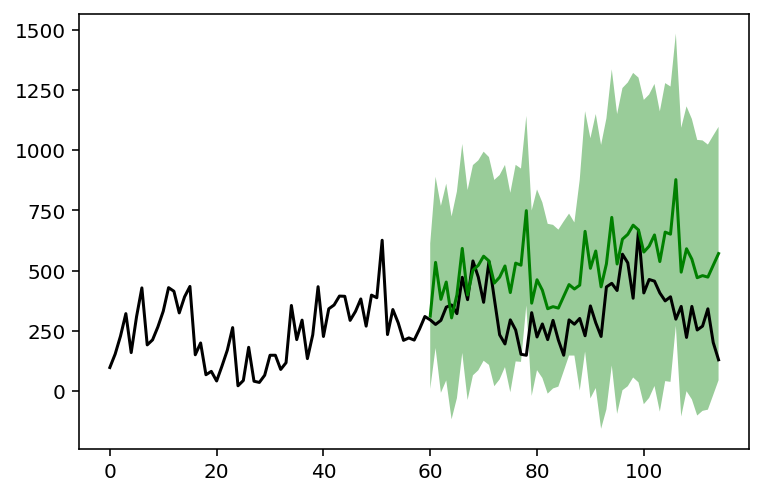

In [29]:
# Plot prediction for the first 100 weeks and a forecast for the following 15 weeks.
simple_dlm.plotPredictN(date=100, N=15)

# Plot prediction for the first 60 weeks and a forecast for the following 55 weeks.
simple_dlm.plotPredictN(date=60, N=55)

The prediction plots above show that while the forecast has shown some success in adapting to the structural shift, i.e. the downward shift in trend in the latter of the series - the confidence bands around the series are still quite wide.

This implies uncertainty in the forecasts being constructed - we cannot be confident that the forecasts being made by the model would be accurate across different sets of data.

## RMSE
<a id="rmse"></a>
[To the Top](#top)

In [30]:
test = ts[-15:]
len(test)

15

[`predictN()`](https://github.com/wwrechard/pydlm/blob/master/pydlm/predict/dlmPredictMod.py#L110) returns a tuple of two lists:
```
(Predicted observation, variance of the predicted observation)
```

In [37]:
forecast = simple_dlm.predictN(date=100, N=15)[0]

np.sqrt(mean_squared_error(test, forecast))

141.4244030613891

In [31]:
np.mean(test)

327.53333333333336

In [38]:
round(141.4244 / 327.5333 * 100, 0)

43.0

**TODO**: interpreting the model accuracy using RMSE.

An RMSE (root mean squared error) of 141 is yielded relative to the mean value of 327 across the test set. The size of the RMSE accounts for 43% of the mean value, indicating that the forecast accuracy needs some improvement.